In [56]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import os
import glob
import pickle

In [75]:
# Define the processed folder path
processed_folder = os.path.abspath(os.path.join('..', 'data', 'processed'))

# List all test and train files
test_files = glob.glob(os.path.join(processed_folder, 'test*'))
train_files = glob.glob(os.path.join(processed_folder, 'train*'))

# Concatenate all test and train files into one DataFrame
data_train = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
data_test = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

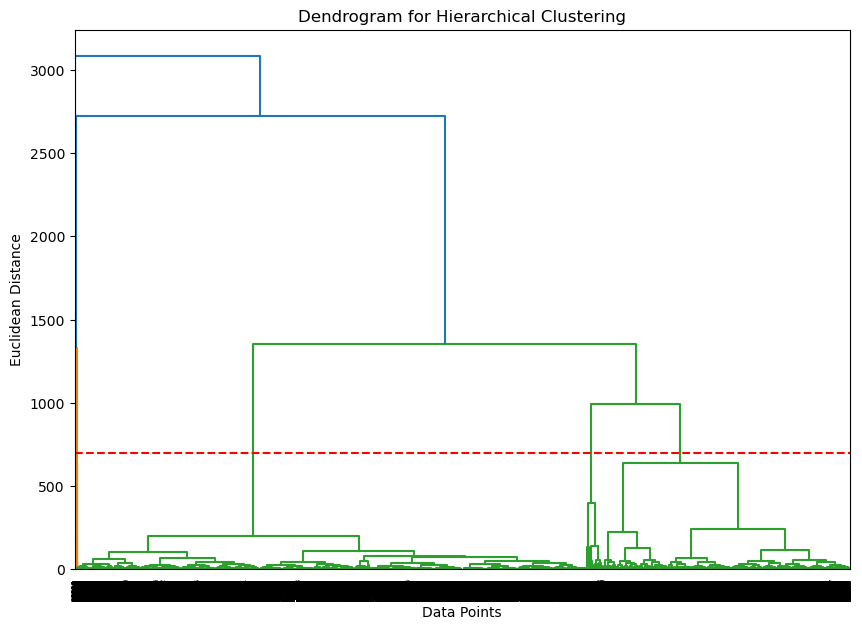

In [76]:
# Perform Hierarchical Clustering
plt.figure(figsize=(10, 7))

# Generate the linkage matrix
Z = sch.linkage(data_train, method='ward')

# Create the dendrogram and plot it
dendrogram = sch.dendrogram(Z)

# Draw a horizontal line at the selected distance to represent the threshold
distance_threshold=700
plt.axhline(y=distance_threshold, color='r', linestyle='--')

plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

In [77]:
# Perform Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, linkage='ward')
data_train_labels=hc.fit_predict(data_train)

In [78]:
data_train['class']=data_train_labels.tolist()
data_train=data_train.drop(data_train[data_train['class']==3].index)
data_train['class']=data_train['class'].map({5:3, 0:0, 1:1, 2:2, 4:4})

output_file = os.path.join('..', 'data/processed/data_alltrain_with_labels.csv')
data_train.to_csv(output_file, index=False)

models_dir = os.path.join('..', 'models')
with open(os.path.join(models_dir, f'hierarchical_clustering_model{distance_threshold}.pkl'), 'wb') as file:
    pickle.dump(hc, file)

In [79]:
print(data_train['class'].value_counts())
print(data_train.columns)

class
4    16827
0     8147
3      528
1       56
2       18
Name: count, dtype: int64
Index(['1', '2', '6', '7', 'percent_to_1000', 'aggregated_trades',
       'price_seen_before', 'class'],
      dtype='object')


In [80]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

X=data_train[['1','2','6','7','percent_to_1000','aggregated_trades','price_seen_before']]
y=data_train['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [81]:
xgb_clf = xgb.XGBClassifier(
                            objective='multi:softmax', 
                            num_class=6, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'])

xgb_clf.fit(X_train, 
            y_train,
            verbose=1,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.00214	validation_0-mlogloss:0.94663	validation_1-merror:0.00266	validation_1-mlogloss:0.94734
[1]	validation_0-merror:0.00172	validation_0-mlogloss:0.64283	validation_1-merror:0.00235	validation_1-mlogloss:0.64385
[2]	validation_0-merror:0.00146	validation_0-mlogloss:0.45405	validation_1-merror:0.00235	validation_1-mlogloss:0.45524
[3]	validation_0-merror:0.00146	validation_0-mlogloss:0.32705	validation_1-merror:0.00219	validation_1-mlogloss:0.32837
[4]	validation_0-merror:0.00136	validation_0-mlogloss:0.23832	validation_1-merror:0.00219	validation_1-mlogloss:0.23982
[5]	validation_0-merror:0.00141	validation_0-mlogloss:0.17508	validation_1-merror:0.00219	validation_1-mlogloss:0.17676
[6]	validation_0-merror:0.00109	validation_0-mlogloss:0.12945	validation_1-merror:0.00172	validation_1-mlogloss:0.13131
[7]	validation_0-merror:0.00099	validation_0-mlogloss:0.09613	validation_1-merror:0.00141	validation_1-mlogloss:0.09808
[8]	validation_0-merror:0.00073	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

In [83]:
import numpy
predictions=xgb_clf.predict(X_train)
unique, counts = numpy.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

{0: 6177, 1: 46, 2: 14, 3: 399, 4: 12546}


In [84]:
models_dir = os.path.join('..', 'models')
with open(os.path.join(models_dir, f'xgb{distance_threshold}.pkl'), 'wb') as file:
    pickle.dump(models_dir, file)